<div style='font-size:larger;line-height:1.5'>
<h3>This notebook takes the three source datasets (HDF files) created via stream2segment, purges them<sup>[1]</sup>, displays some distributions and creates the following datasets<sup>[2]</sup>:</h3>
    <ul>
    <li><b>allset_train</b>: all inliers of all datasets
        <li><b>allset_test</b>: all outliers of all dataset, plus N randomly sampled inliers (removed from allset_train) where N roughly equals the number of all outliers of all datasets
        <li><b>allset_unlabelled</b>: all unlabelled segments (HDF rows) of all datasets
        <li><b>allset_artifacts</b>: all artifacts of all datasets. Artifacts are those semgnent with a PSD value of approximately -32076 (or similar), which (after inspection) allgedly stems from a constant miniSeed data. We heuristically derived these artifacts by setting all PSD values lower than -1000
    </ul>  
</div>

<sup>[1]</sup> (remove NA, i.e. rows with ALL PSd values NaN)<br>
<sup>[2]</sup> the new datasets are saved in the same folder of the three source datasets


In [1]:
import importlib

import os, pandas as pd, numpy as np
from joblib import dump, load
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# from sod.core.evaluation import normalize
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
import re

rootpath = os.path.join(os.path.dirname(os.getcwd()), 'datasets')
assert os.path.isdir(rootpath)

def read_dataset(name):
    datasetpath = os.path.join(rootpath, name + '.hdf')
    assert os.path.isfile(datasetpath)
    print('Reading dataset %s' % name)
    dataset = pd.read_hdf(datasetpath)
    dataset.channel_code = dataset.channel_code.astype('category')
    dataset.location_code = dataset.location_code.astype('category')
    print('%s columns:' % name)
    print(dataset.columns.tolist())
    return dataset


def save_dataset(dataset, name):
    '''saves dataset (oandas dataframe). For security reasons
    (overwriting - i.e., loosing data of - big datasets might be really dangarous),
    this method raises if the file already exists'''
    datasetpath = os.path.abspath(os.path.join(rootpath, name + '.hdf'))
    if os.path.isfile(datasetpath):
        raise ValueError('Can not save dataset. File exists: "%s"' % datasetpath)
    if not re.match('^[a-zA-Z_]+$', name):
        raise ValueError('Can not save dataset. Invalid table name: "%s"' % name)
    dataset.to_hdf(
        datasetpath,
        format='table', mode='w',
        key=name
    )
    print('File saved under %s' % datasetpath)

    
def split_in_classes(dataset):
    return {
        'Hand labelled, inliers': dataset[dataset.hand_labelled & (~dataset.outlier)],
        'Hand labelled, outliers': dataset[dataset.hand_labelled & (dataset.outlier)],
        'other': dataset[~dataset.hand_labelled],
    }


def print_stats(dataset):
    dfrs = split_in_classes(dataset)
    for c, dfr in dfrs.items():
        string = c + " (%d rows)" % len(dfr)
        if dfr.empty:
            continue
        print()
        print(string)
        print('-' * len(string))
        print(sod_core_dataset._dfinfo(dfr).to_string())


def get_psd_columns(dataset):
    psd_cols = [_ for _ in dataset.columns if _.startswith('psd@')]
    return psd_cols


def remove_na(dataset):
    psd_cols = get_psd_columns(dataset)
    print('Dropping NA (columns: %s, how=\'all\')' % str(psd_cols))
    _len = len(dataset)
    ret = dataset.dropna(subset=psd_cols, how='all')  # , inplace=True)
    print("%d rows removed (all NA)" % (_len - len(dataset)))
    return ret


def drop_artifacts(dataset):
    TH = -1000
    print('Removing artifacts (segments with all rows < %f)' % TH)
    and_cond = None
    is_na = pd.isna
    psd_cols = get_psd_columns(dataset)
    for i,c in enumerate(psd_cols):
        th_cond = (dataset[c] < TH).values | pd.isna(dataset[c])
        if i == 0:
            and_cond = th_cond
            or_cond = th_cond
        else:
            and_cond = and_cond & th_cond
            or_cond = or_cond & th_cond

    print('%d rows have at least one psd < %f' % (and_cond.sum(), TH))
    print('%d rows have ALL psd < %f' % (or_cond.sum(), TH))

    _or_df = dataset[or_cond]
    _and_df = dataset[and_cond]
    _diff_df = _or_df[~_or_df['Segment.db.id'].isin(_and_df['Segment.db.id'])]
    if len(_diff_df):
        print()
        maxelm = max(10, len(_diff_df))
        print("Showing %d of %d elements have one but not all PSD < %f" % (maxelm, len(_diff_df), TH))
        print(_diff_df[col][:maxelm])
        raise ValueError("%d elements have one but not all PSD < %f" % (len(_diff_df), TH))
    else:
        print("CHECK OK: no element has one but not all PSD < %f" % TH)
   
    return dataset[~and_cond], dataset[and_cond]

def print_dec(string):
    print()
    print('=' * len(string))
    print(string)
    print('=' * len(string))

    
# DEFINING SOME PLOT FUNCTONS:


import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
import sod.core.dataset as sod_dataset
importlib.reload(sod_dataset)
import matplotlib.pyplot as plt
import numpy as np


# defining matplotlib functions
import matplotlib.pyplot as plt
from contextlib import contextmanager

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

            
def set_same_lim(axes, x=True, y=True):
    minx, maxx, miny, maxy = np.inf, -np.inf, np.inf, -np.inf
    for ax in axes:
        minx = min(ax.get_xlim()[0], minx)
        maxx = max(ax.get_xlim()[1], maxx)
        miny = min(ax.get_ylim()[0], miny)
        maxy = max(ax.get_ylim()[1], maxy)
    for ax in axes:
        if x:
            ax.set_xlim(minx, maxx)
        if y:
            ax.set_ylim(miny, maxy)
    if x and y:
        return minx, maxx, miny, maxy
    elif x:
        return minx, maxx
    elif y:
        return miny, maxy
    else:
        raise ValueError('x and y can not be both False')

        
def plot_dist(dataset):
    psd_cols = get_psd_columns(dataset)
    # bins = np.arange(-350, 150, 5)

    # use colors which are ok also for grayscale:
    colors = ['#1f6784', '#ff7f3e', '#9cf09c']

    features = ['magnitude', 'distance_km'] + psd_cols
    featurelabels = [_.title() for _ in features]

    axslist=[]
    ylims = []
    
    dfrs = split_in_classes(dataset)

    with plotparams({'figure.figsize': (12, 24), 'font.size': 12, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
        fig, allaxs = plt.subplots(len(features), len(dfrs))
        # pltsubplots accepts also gridspec_kw to fix the subplots relative size, but apparently we do not
        # need it: , gridspec_kw={'height_ratios': [1] + [1]*(len(features)-1)})
        for i, col in enumerate(features):
            rowaxs = allaxs[i]
            
            for j, (name, datafr_) in enumerate(dfrs.items()):
                axs = rowaxs[j]
                axs.set_xlabel(featurelabels[i] + ' (%s)' % name)
                if datafr_.empty:
                    axs.set_xlabel(featurelabels[i] + ' (%s), NO DATA' % name)
                    continue
                data = datafr_[col]
                axs.hist(data, bins=19, rwidth=.75,  # if i < 2 else bins,
                         log=True, histtype='bar', stacked=True)  # , label=featurelabels[i] + ' (%s)' % name
                         #color=colors[:len(data)])
                axs.grid()

            set_same_lim(rowaxs)

    plt.tight_layout()
    plt.show()

print('DONE')

DONE


In [2]:
print('READING DATASET, PLEASE WAIT IT MIGHT TAKE FEW MINUTES')
databases = ['sod_chile_at_rs5', 's2s_2019_03_at_rs5', 'me_at_rz_minus_vm258']
datasets = {}
for name in databases:
    print()
    datasets[name] = read_dataset(name)
print('DONE')

READING DATASET, PLEASE WAIT IT MIGHT TAKE FEW MINUTES

Reading dataset sod_chile_at_rs5
sod_chile_at_rs5 columns:
['hand_labelled', 'length_sec', 'outlier', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec', 'psd@5sec', 'psd@9sec', 'window_type', 'amplitude_ratio', 'event_id', 'station_id', 'event_time', 'location_code', 'channel_code', 'magnitude', 'distance_km', 'dataset_id', 'Segment.db.id']

Reading dataset s2s_2019_03_at_rs5
s2s_2019_03_at_rs5 columns:
['hand_labelled', 'length_sec', 'outlier', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec', 'psd@5sec', 'psd@9sec', 'window_type', 'amplitude_ratio', 'event_id', 'station_id', 'event_time', 'location_code', 'channel_code', 'magnitude', 'distance_km', 'dataset_id', 'Segment.db.id']

Reading dataset me_at_rz_minus_vm258
me_at_rz_minus_vm258 columns:
['hand_labelled', 'length_sec', 'outlier', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', '

In [3]:
artifacts = []
for name, dataset in list(datasets.items()):
    print()
    print_dec('%s: statistics' % name)
    print_stats(dataset)
    print_dec('%s: remove NA' % name)
    dataset = remove_na(dataset)
    print_dec('%s: splitting artifacts and normal instances' % name)
    dataset, dataset_artf = drop_artifacts(dataset)
    # newdfrs.append(dataset)
    artifacts.append(dataset_artf)
    print_dec('%s: Final statistics' % name)
    print_stats(dataset)
    datasets[name] = dataset

print()
print('DONE')



sod_chile_at_rs5: statistics

Hand labelled, inliers (159300 rows)
------------------------------------
                        Min      Median           Max    #NAs  #<1Perc.  #>99Perc.
length_sec       120.950000  262.950000   1276.950000       0      1539       1533
psd@0.05sec     -155.569473 -116.863228    -63.698372  154146        52         52
psd@0.1sec      -146.651794  -92.504749    -23.194212       0      1593       1593
psd@0.2sec      -156.211334  -93.619106    -19.815527       0      1593       1593
psd@0.5sec      -157.420259  -96.275398    -21.758630       0      1593       1593
psd@1sec        -150.873363 -103.241486    -23.994206       0      1593       1593
psd@2sec        -144.344511 -111.287855    -23.488951       0      1593       1593
psd@3sec        -140.272231 -115.472958    -28.898031       0      1593       1593
psd@5sec        -142.837497 -117.466443    -34.420378       0      1593       1593
psd@9sec        -161.260922 -119.035368    -34.557985       0   

                          Min      Median         Max    #NAs  #<1Perc.  #>99Perc.
length_sec       1.000000e+00  130.160000  479.350000       0    120839     121770
psd@0.05sec     -2.918003e+02 -120.318150  204.248935   15976    121649     121649
psd@0.1sec      -2.940196e+02 -121.636597  199.380165       0    121809     121809
psd@0.2sec      -2.921181e+02 -121.890596  193.831731      80    121808     121808
psd@0.5sec      -2.985523e+02 -122.371181  186.093224     149    121807     121807
psd@1sec        -2.976758e+02 -122.319364  182.748209     379    121805     121805
psd@2sec        -2.923712e+02 -120.903343  185.138463     753    121801     121801
psd@3sec        -2.955128e+02 -120.746489  183.409652    2214    121786     121786
psd@5sec        -2.996626e+02 -123.484802  184.454195    6250    121746     121746
psd@9sec        -3.086391e+02 -129.716248  188.779510  412175    117687     117687
amplitude_ratio  1.192093e-07    0.001195  256.000000       0    117535     121809
magn

                          Min       Median           Max     #NAs  #<1Perc.  #>99Perc.
length_sec       1.000000e+00   533.100000  9.264000e+02        0     49400      55959
psd@0.05sec     -2.570055e+02  -128.508865  8.194607e+02  2245605     33506      33506
psd@0.1sec      -3.102925e+02  -134.421890  7.821327e+02    82892     55133      55133
psd@0.2sec      -3.176727e+02  -140.124420  7.692205e+02        3     55961      55962
psd@0.5sec      -3.219416e+02  -141.181884  7.513480e+02       33     55961      55962
psd@1sec        -3.217695e+02  -136.607759  7.398683e+02       88     55961      55961
psd@2sec        -3.140864e+02  -129.115984  7.271926e+02      151     55961      55961
psd@3sec        -3.086281e+02  -125.756817  7.209501e+02      174     55959      55960
psd@5sec        -3.124313e+02  -124.213904  6.959896e+02      253     55959      55959
psd@9sec        -3.207423e+02  -133.859206  6.814097e+02      480     55956      55957
amplitude_ratio  1.192093e-07     0.000644 



sod_chile_at_rs5: distributions


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


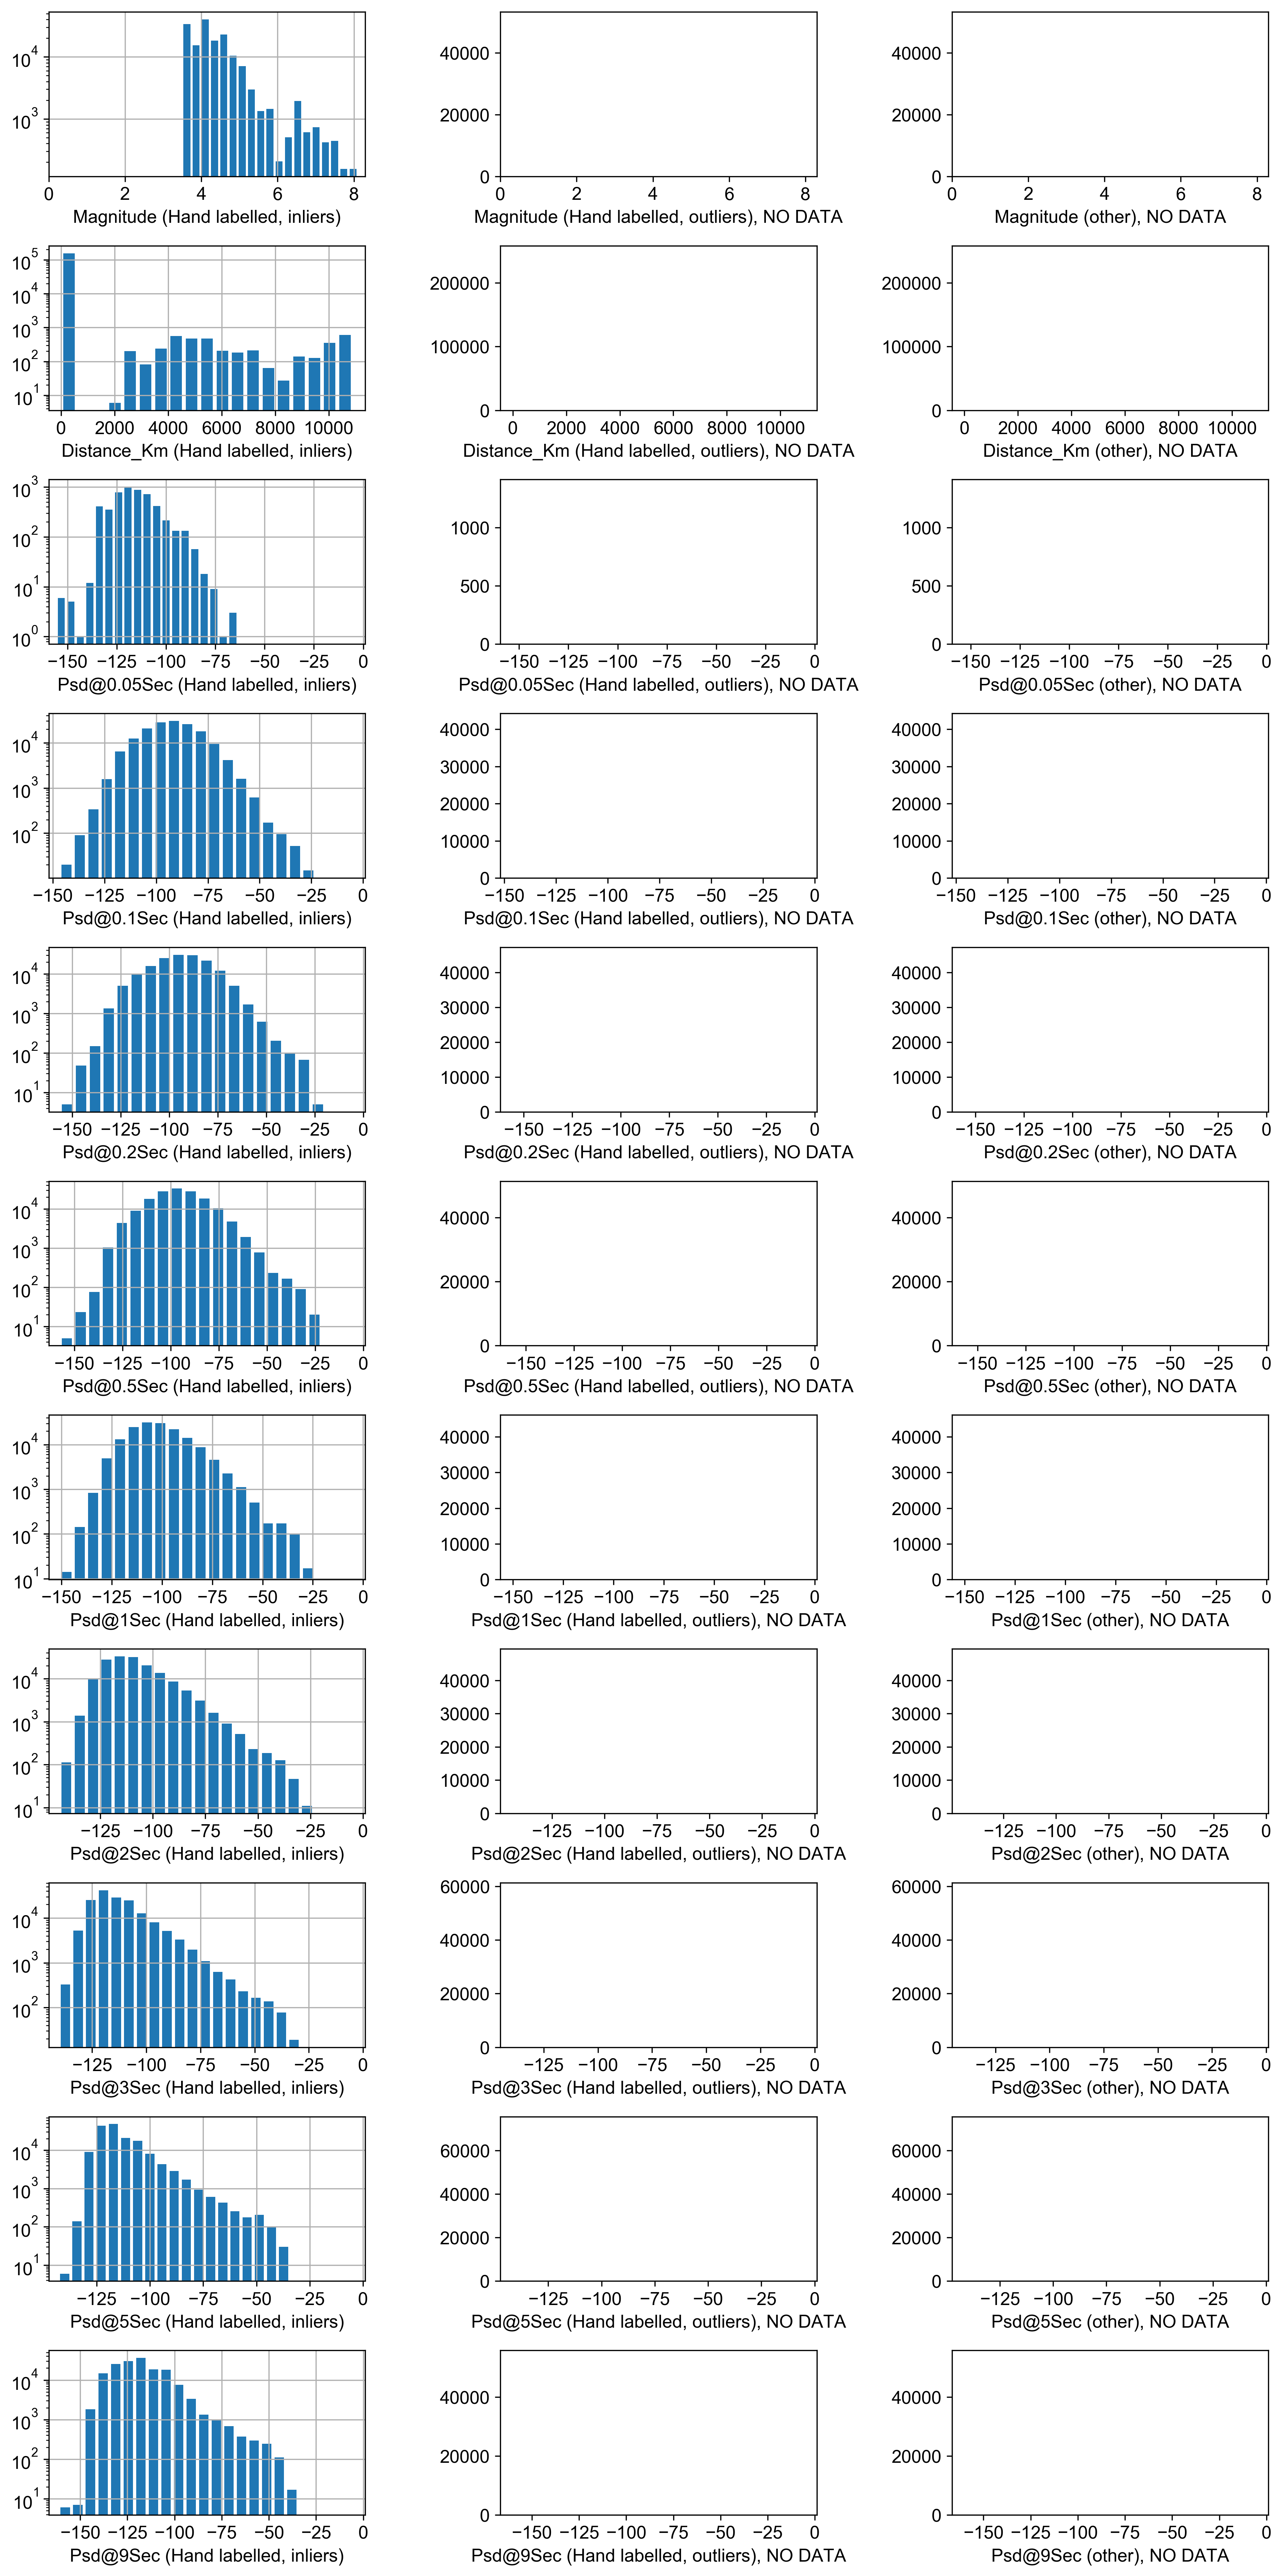



s2s_2019_03_at_rs5: distributions


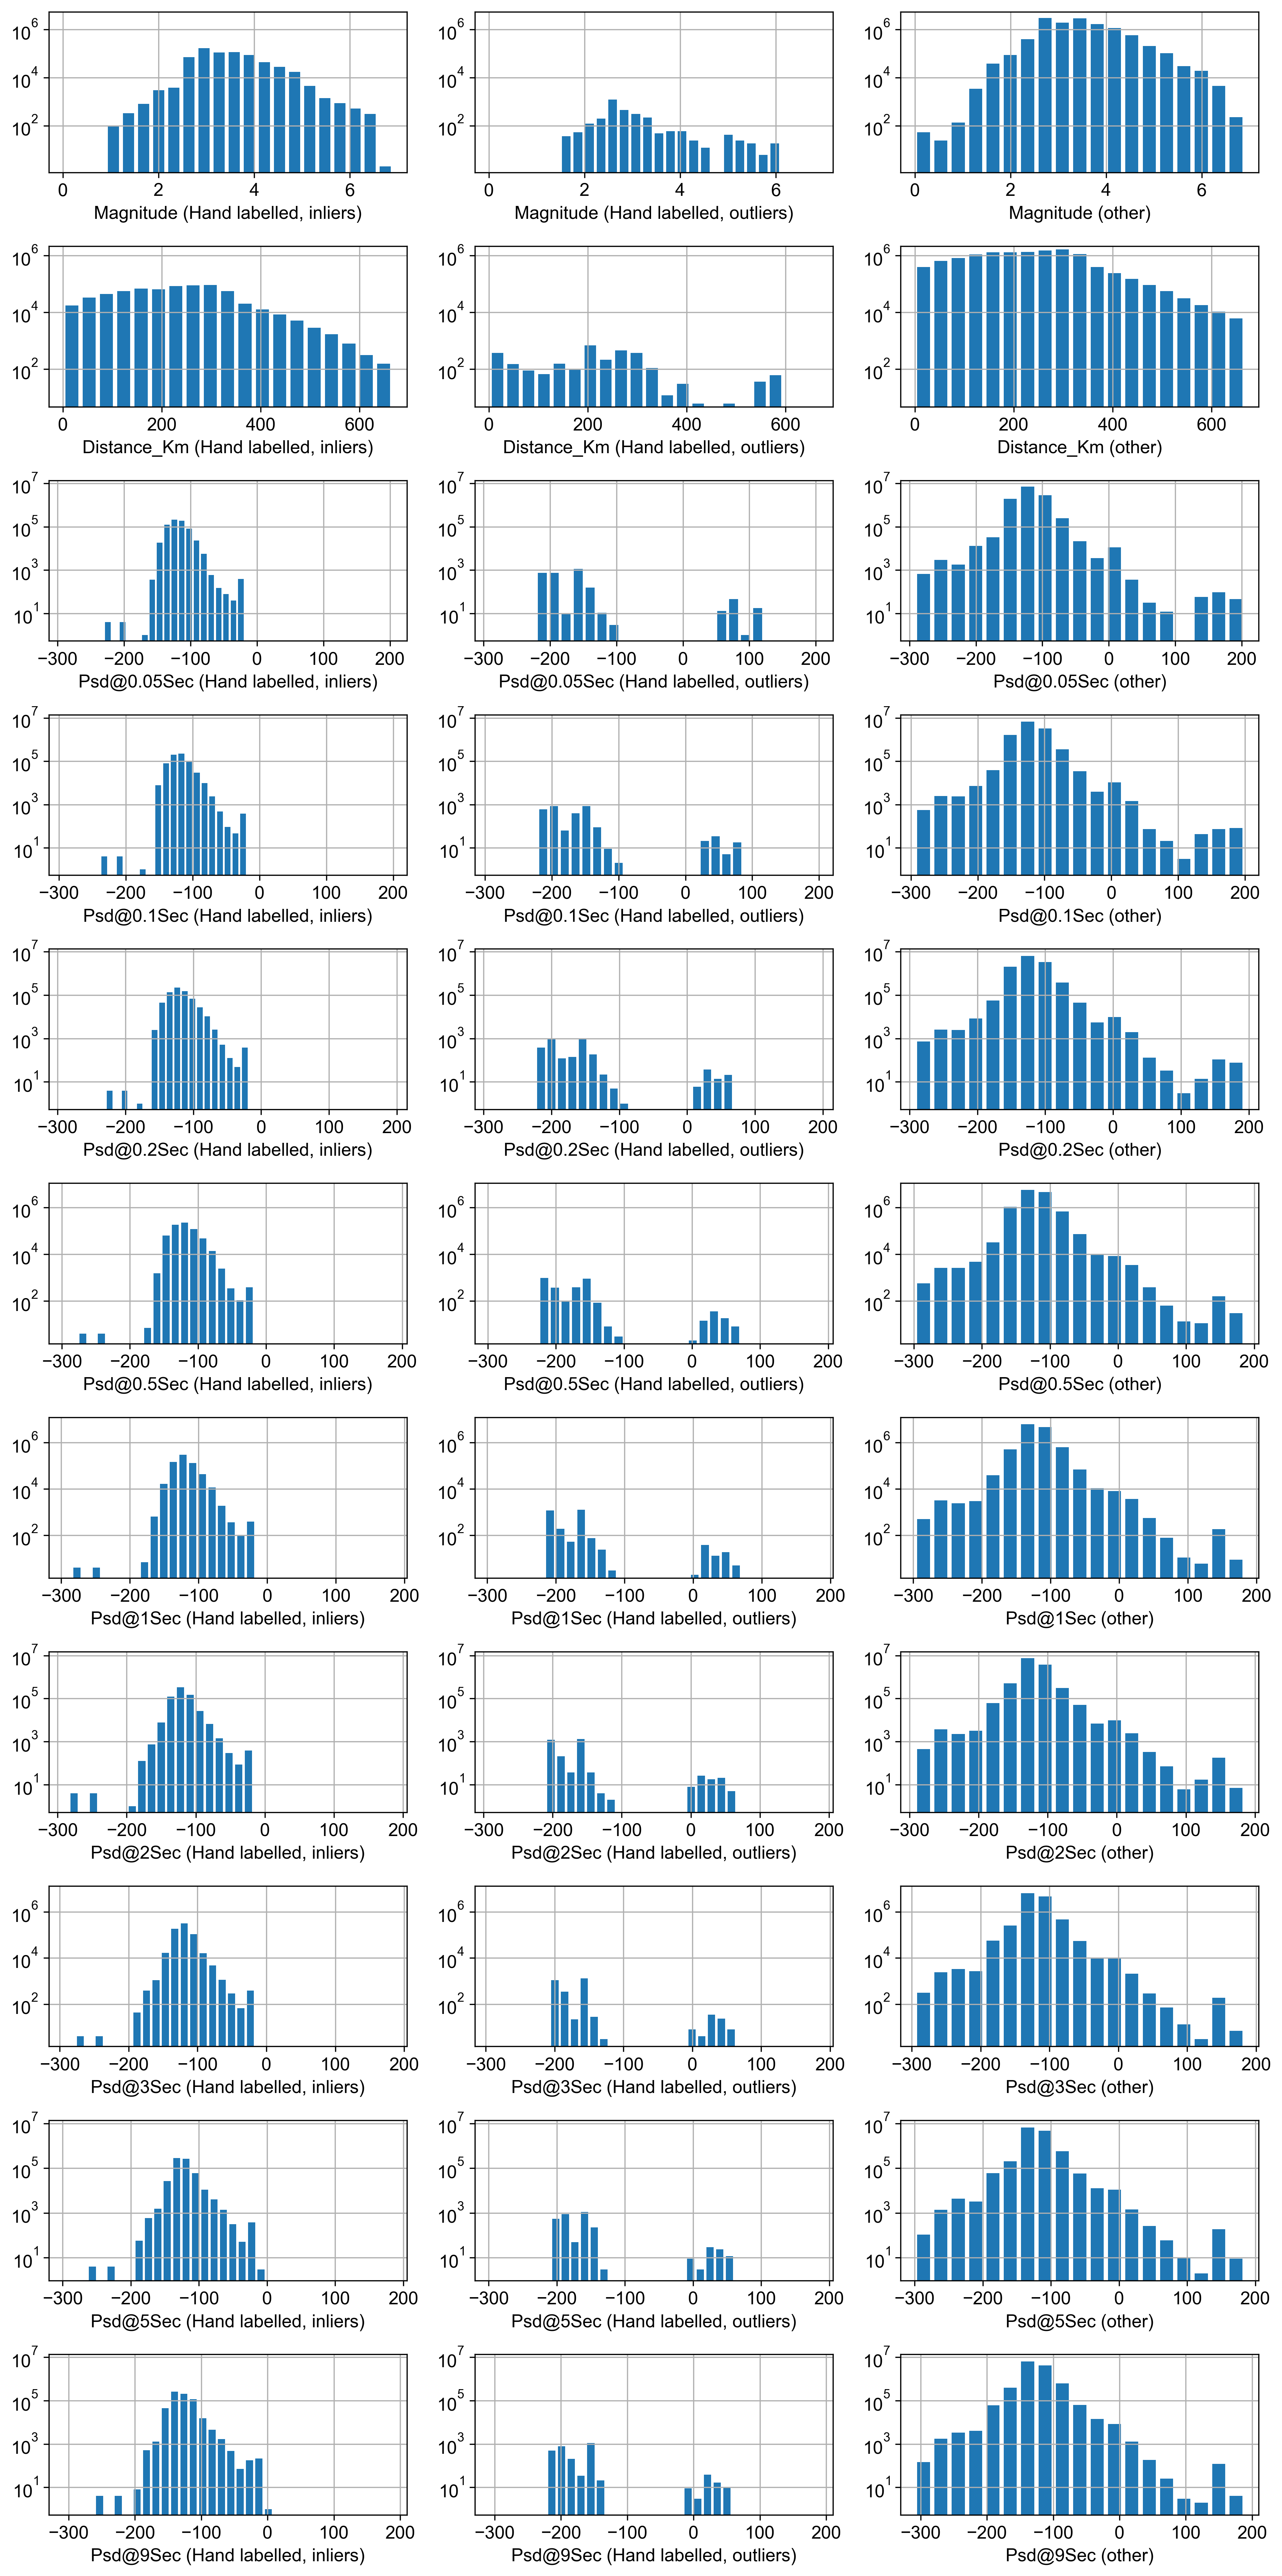



me_at_rz_minus_vm258: distributions


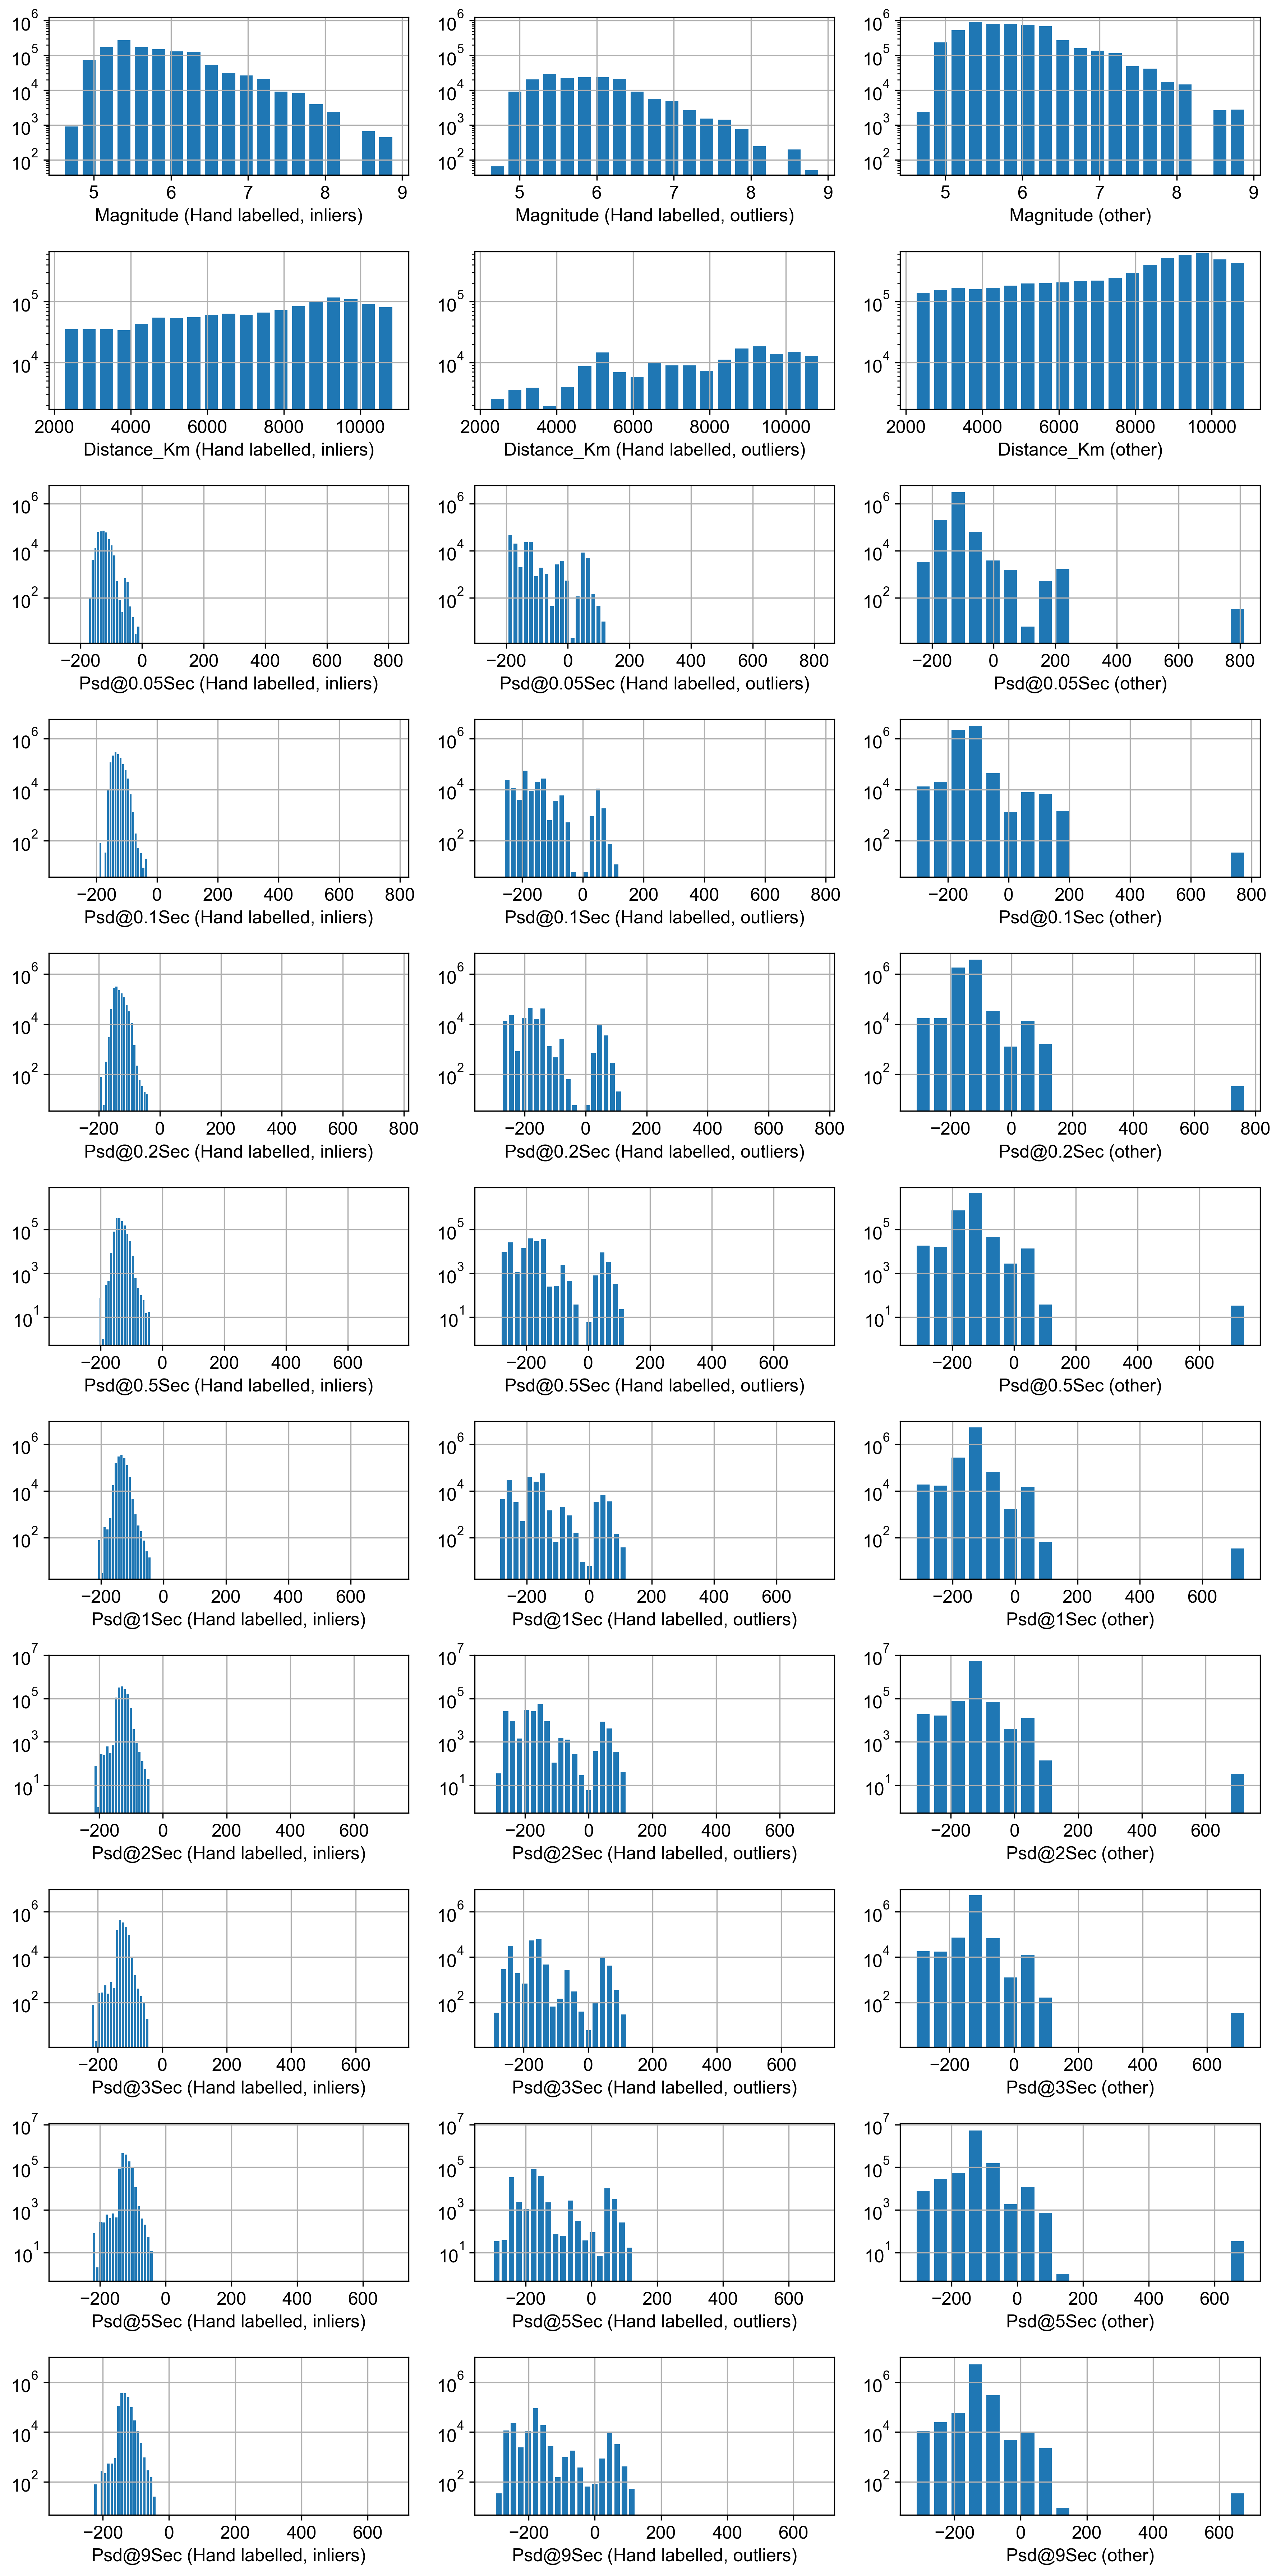

In [4]:
# distributions plots
for name, dataset in datasets.items():
    print()
    print_dec('%s: distributions' % name)
    plot_dist(dataset)

In [5]:
new_datasets = {}

print_dec('Splitting train test / artifacts and saving')
# Saving artifacts
allset_artifacts = pd.concat(artifacts, sort=False, axis=0, copy=True)
name, dfr = 'allset_artifacts', allset_artifacts
print_dec('Saving dataset "%s" (%d instances)' % (name, len(dfr)))
new_datasets[name] = dfr
# save_dataset(dfr, name)

allset = pd.concat(datasets.values(), sort=False, axis=0, copy=True)

# Saving testset:
allset_unlabelled = allset[~allset.hand_labelled]
name, dfr = 'allset_unlabelled', allset_unlabelled
print_dec('Saving dataset "%s" (%d instances)' % (name, len(dfr)))
assert not dfr.hand_labelled.values.any()
assert sorted(pd.unique(dfr.outlier)) == [False]
new_datasets[name] = dfr
# save_dataset(dfr, name)

dfr = allset[allset.hand_labelled]
allset_train = dfr[~dfr.outlier]
allset_test = dfr[dfr.outlier]

print_dec('Creating uniform test set by randomnly sampling from train')
print('Allset train: %d' % len(allset_train))
print('Allset test: %d' % len(allset_test))

percent = np.true_divide(len(allset_test), len(allset_train))
if percent >=1:
    raise ValueError('Something went wrong: you are supposed to have more training segments than test segments')
print_dec('Putting %f %% of train data into test (sampling by channel)' % percent)
allset_trains = []
allset_tests = [allset_test]
# iterate over each channel and randomly sample the given amount of sample
for _, dfr in allset_train.groupby(['dataset_id', 'station_id', 'channel_code', 'location_code', 'window_type']):
    dfr = dfr.reset_index(drop=True)
    to_test = dfr.sample(frac=percent, random_state=1)
    to_train = dfr[~dfr.index.isin(to_test.index)]
    # print('len(train): %d  len(test): %d len(all): %d' % (len(to_train), len(to_test), len(dfr)))
    assert len(to_test) + len(to_train) == len(dfr)
    allset_trains.append(to_train)
    allset_tests.append(to_test)

allset_train = pd.concat(allset_trains, sort=False, axis=0, copy=True)
allset_test = pd.concat(allset_tests, sort=False, axis=0, copy=True)

assert np.all(allset_test.hand_labelled)
assert sorted(pd.unique(allset_test.outlier)) == [False, True]
assert np.all(allset_train.hand_labelled)
assert sorted(pd.unique(allset_train.outlier)) == [False]

print('After sampling:')
print('Allset train: %d' % len(allset_train))
print('Allset test: %d' % len(allset_test))
new_datasets['allset_train'] = allset_train
new_datasets['allset_test'] = allset_test
# save_dataset(dfr_train, 'allset_train')
# save_dataset(dfr_test, 'allset_test')
    


Splitting train test / artifacts and saving

Saving dataset "allset_artifacts" (67734 instances)

Saving dataset "allset_unlabelled" (17776979 instances)

Creating uniform test set by randomnly sampling from train
Allset train: 2070828
Allset test: 178449

Putting 0.086173 % of train data into test (sampling by channel)
After sampling:
Allset train: 1892367
Allset test: 356910




allset_artifacts: distributions


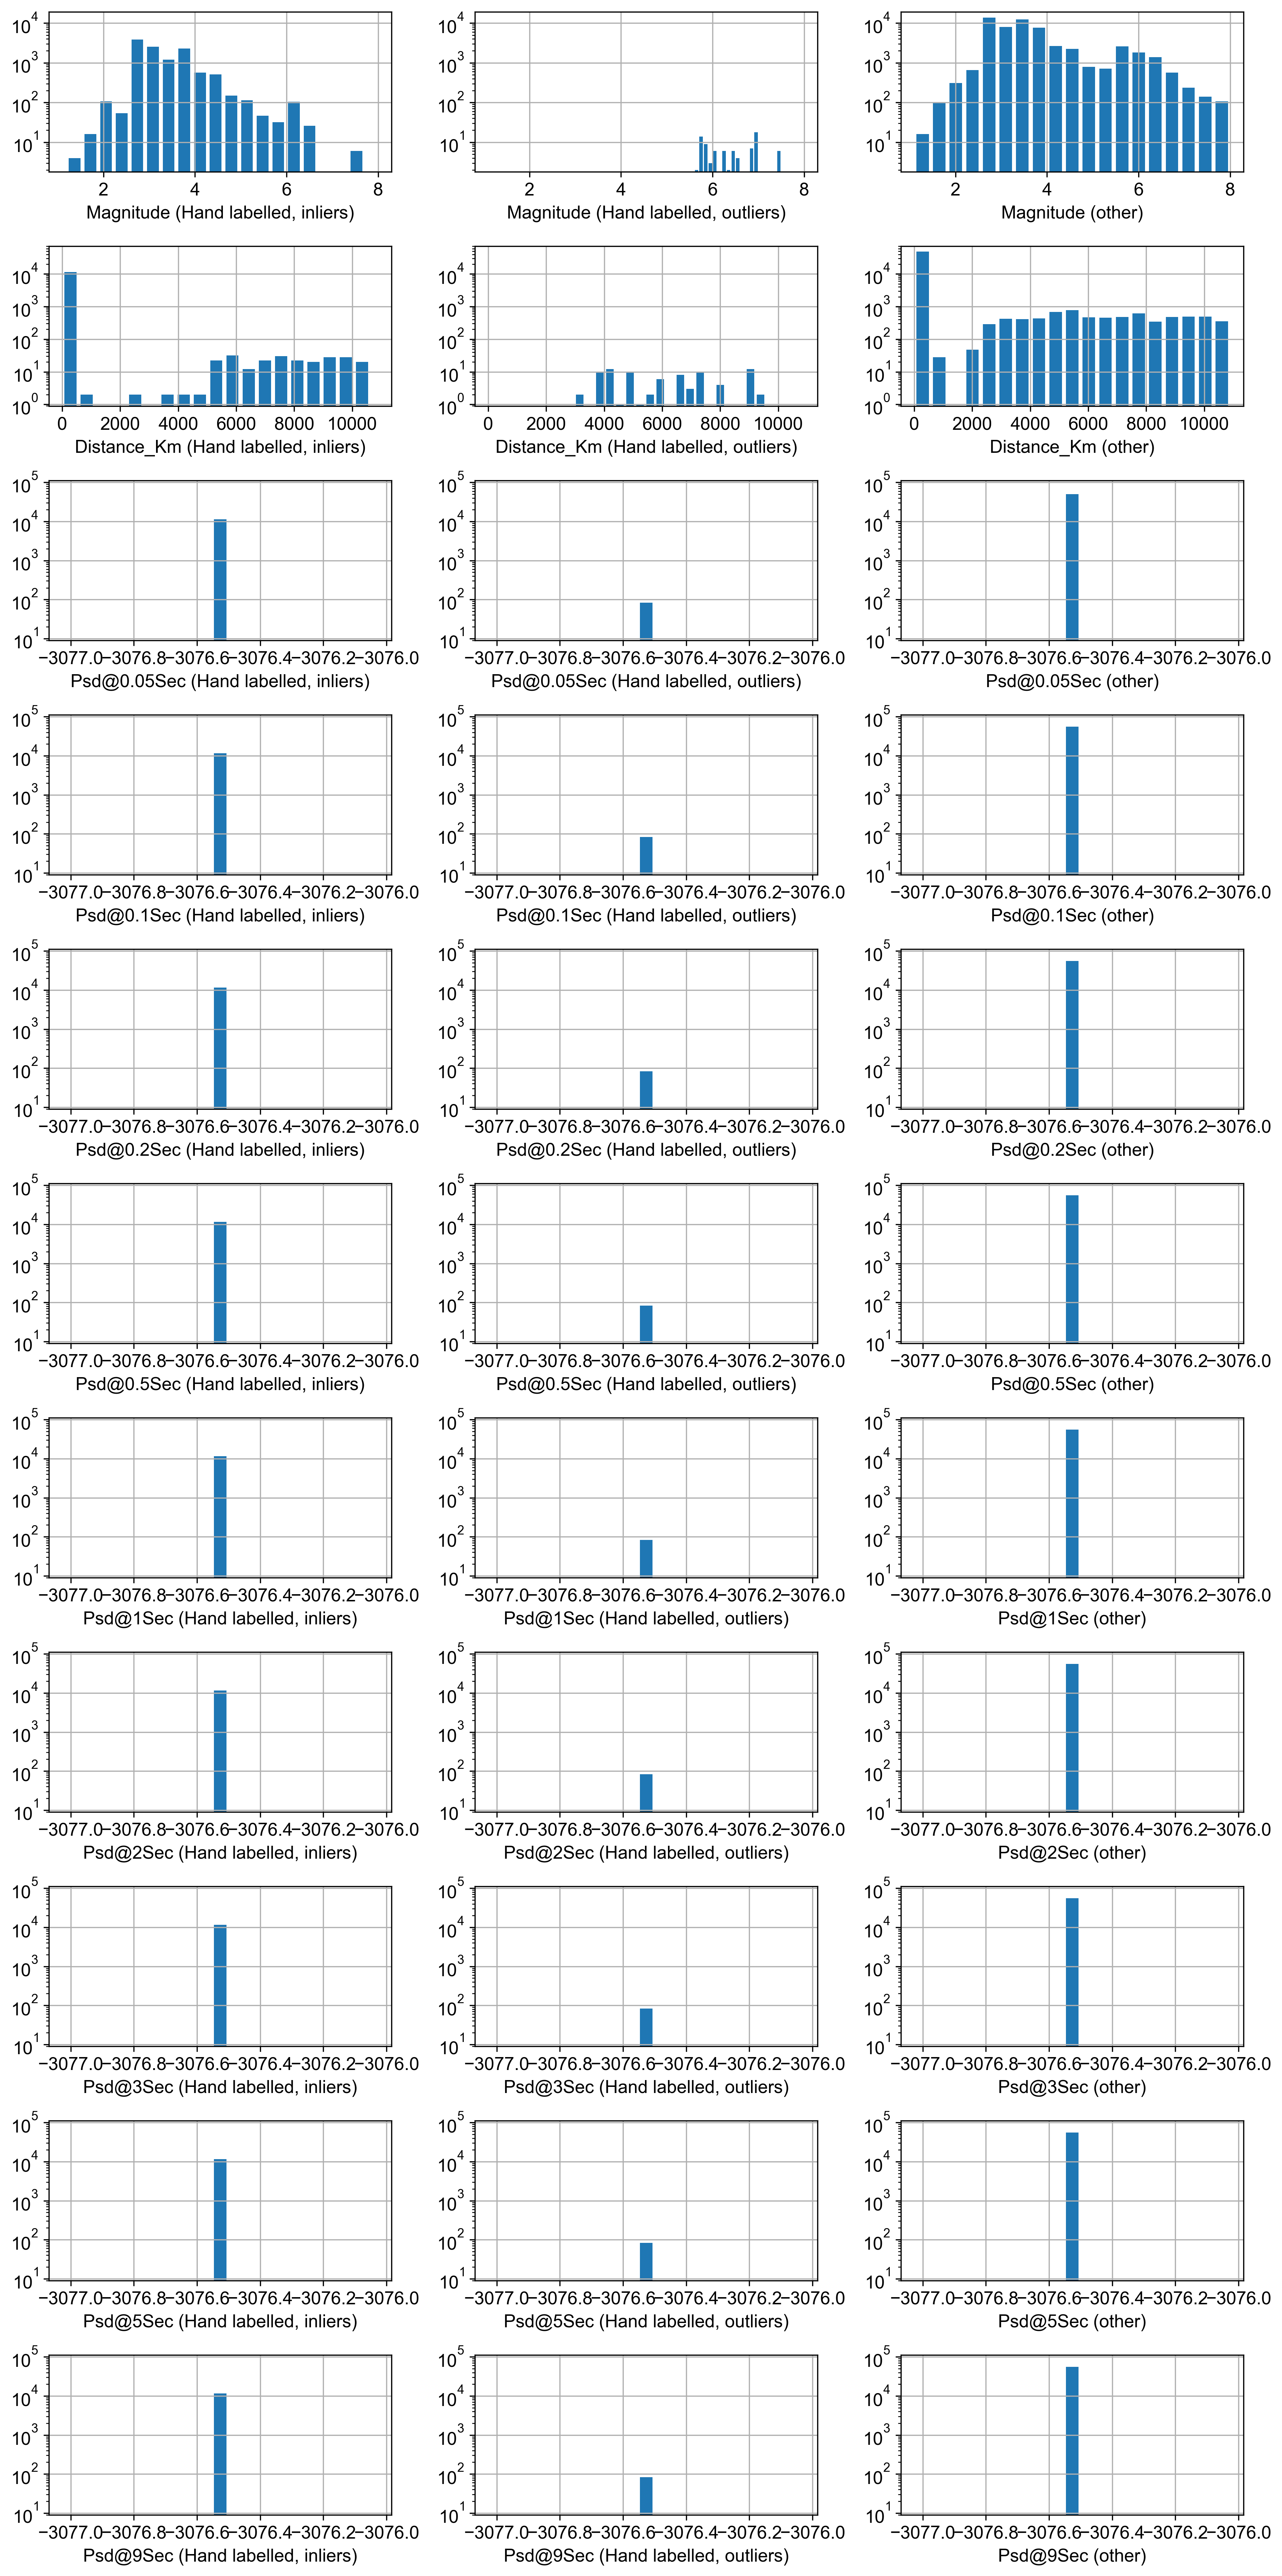



allset_unlabelled: distributions


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


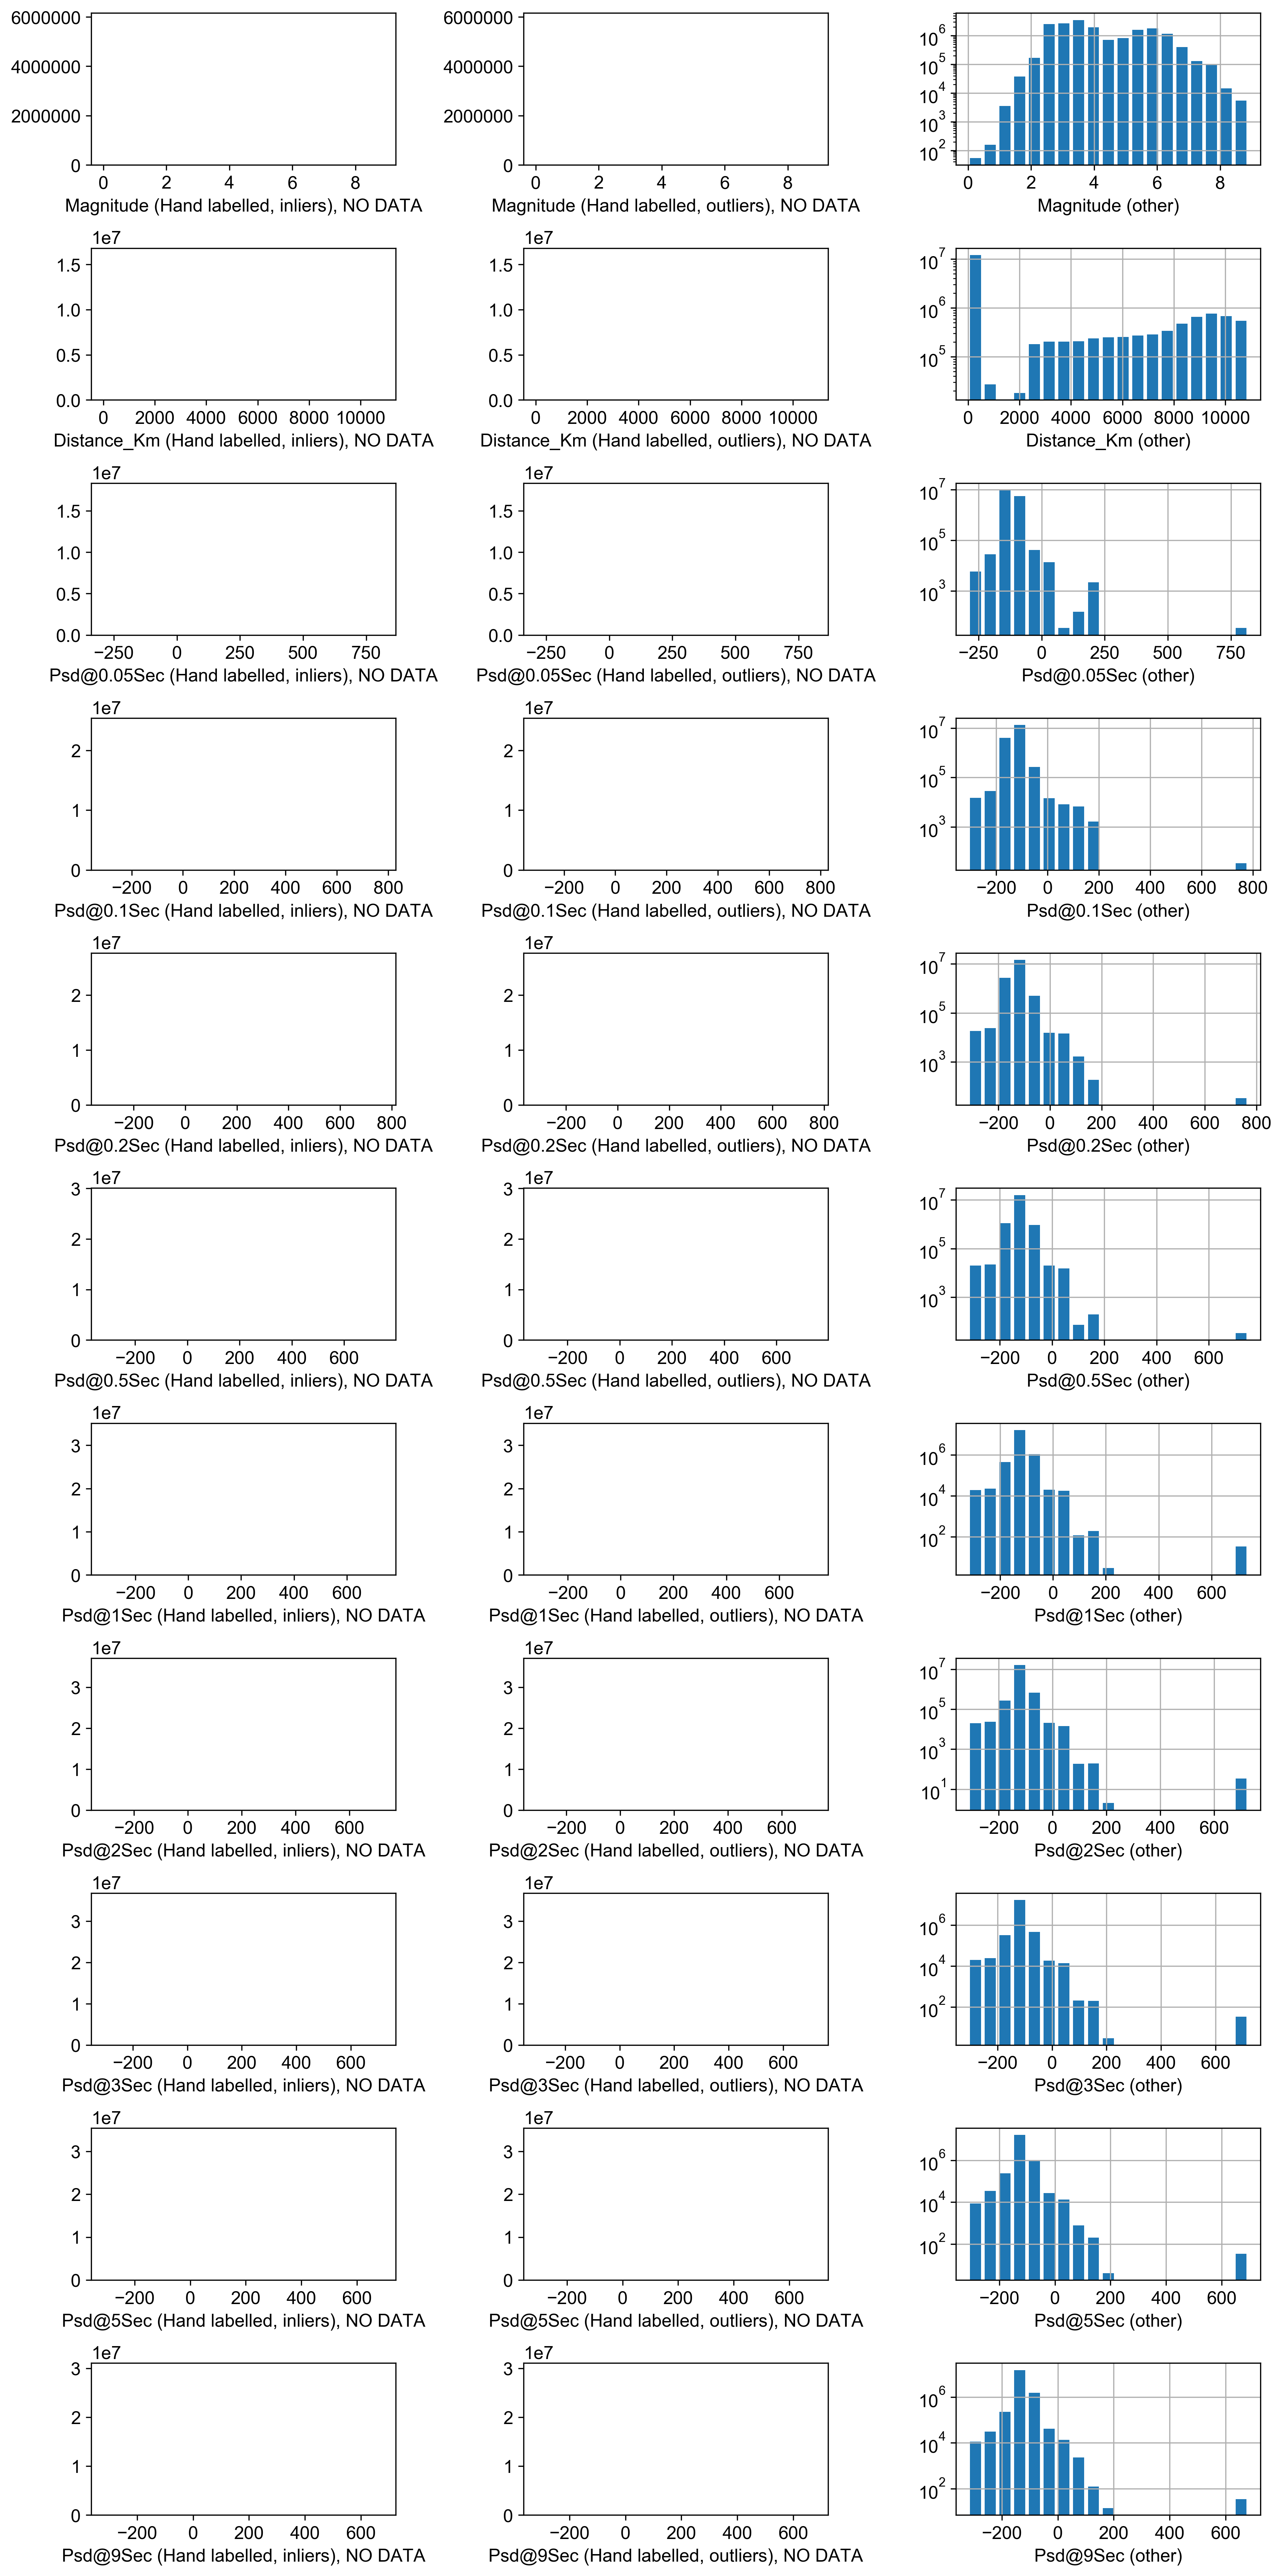



allset_train: distributions


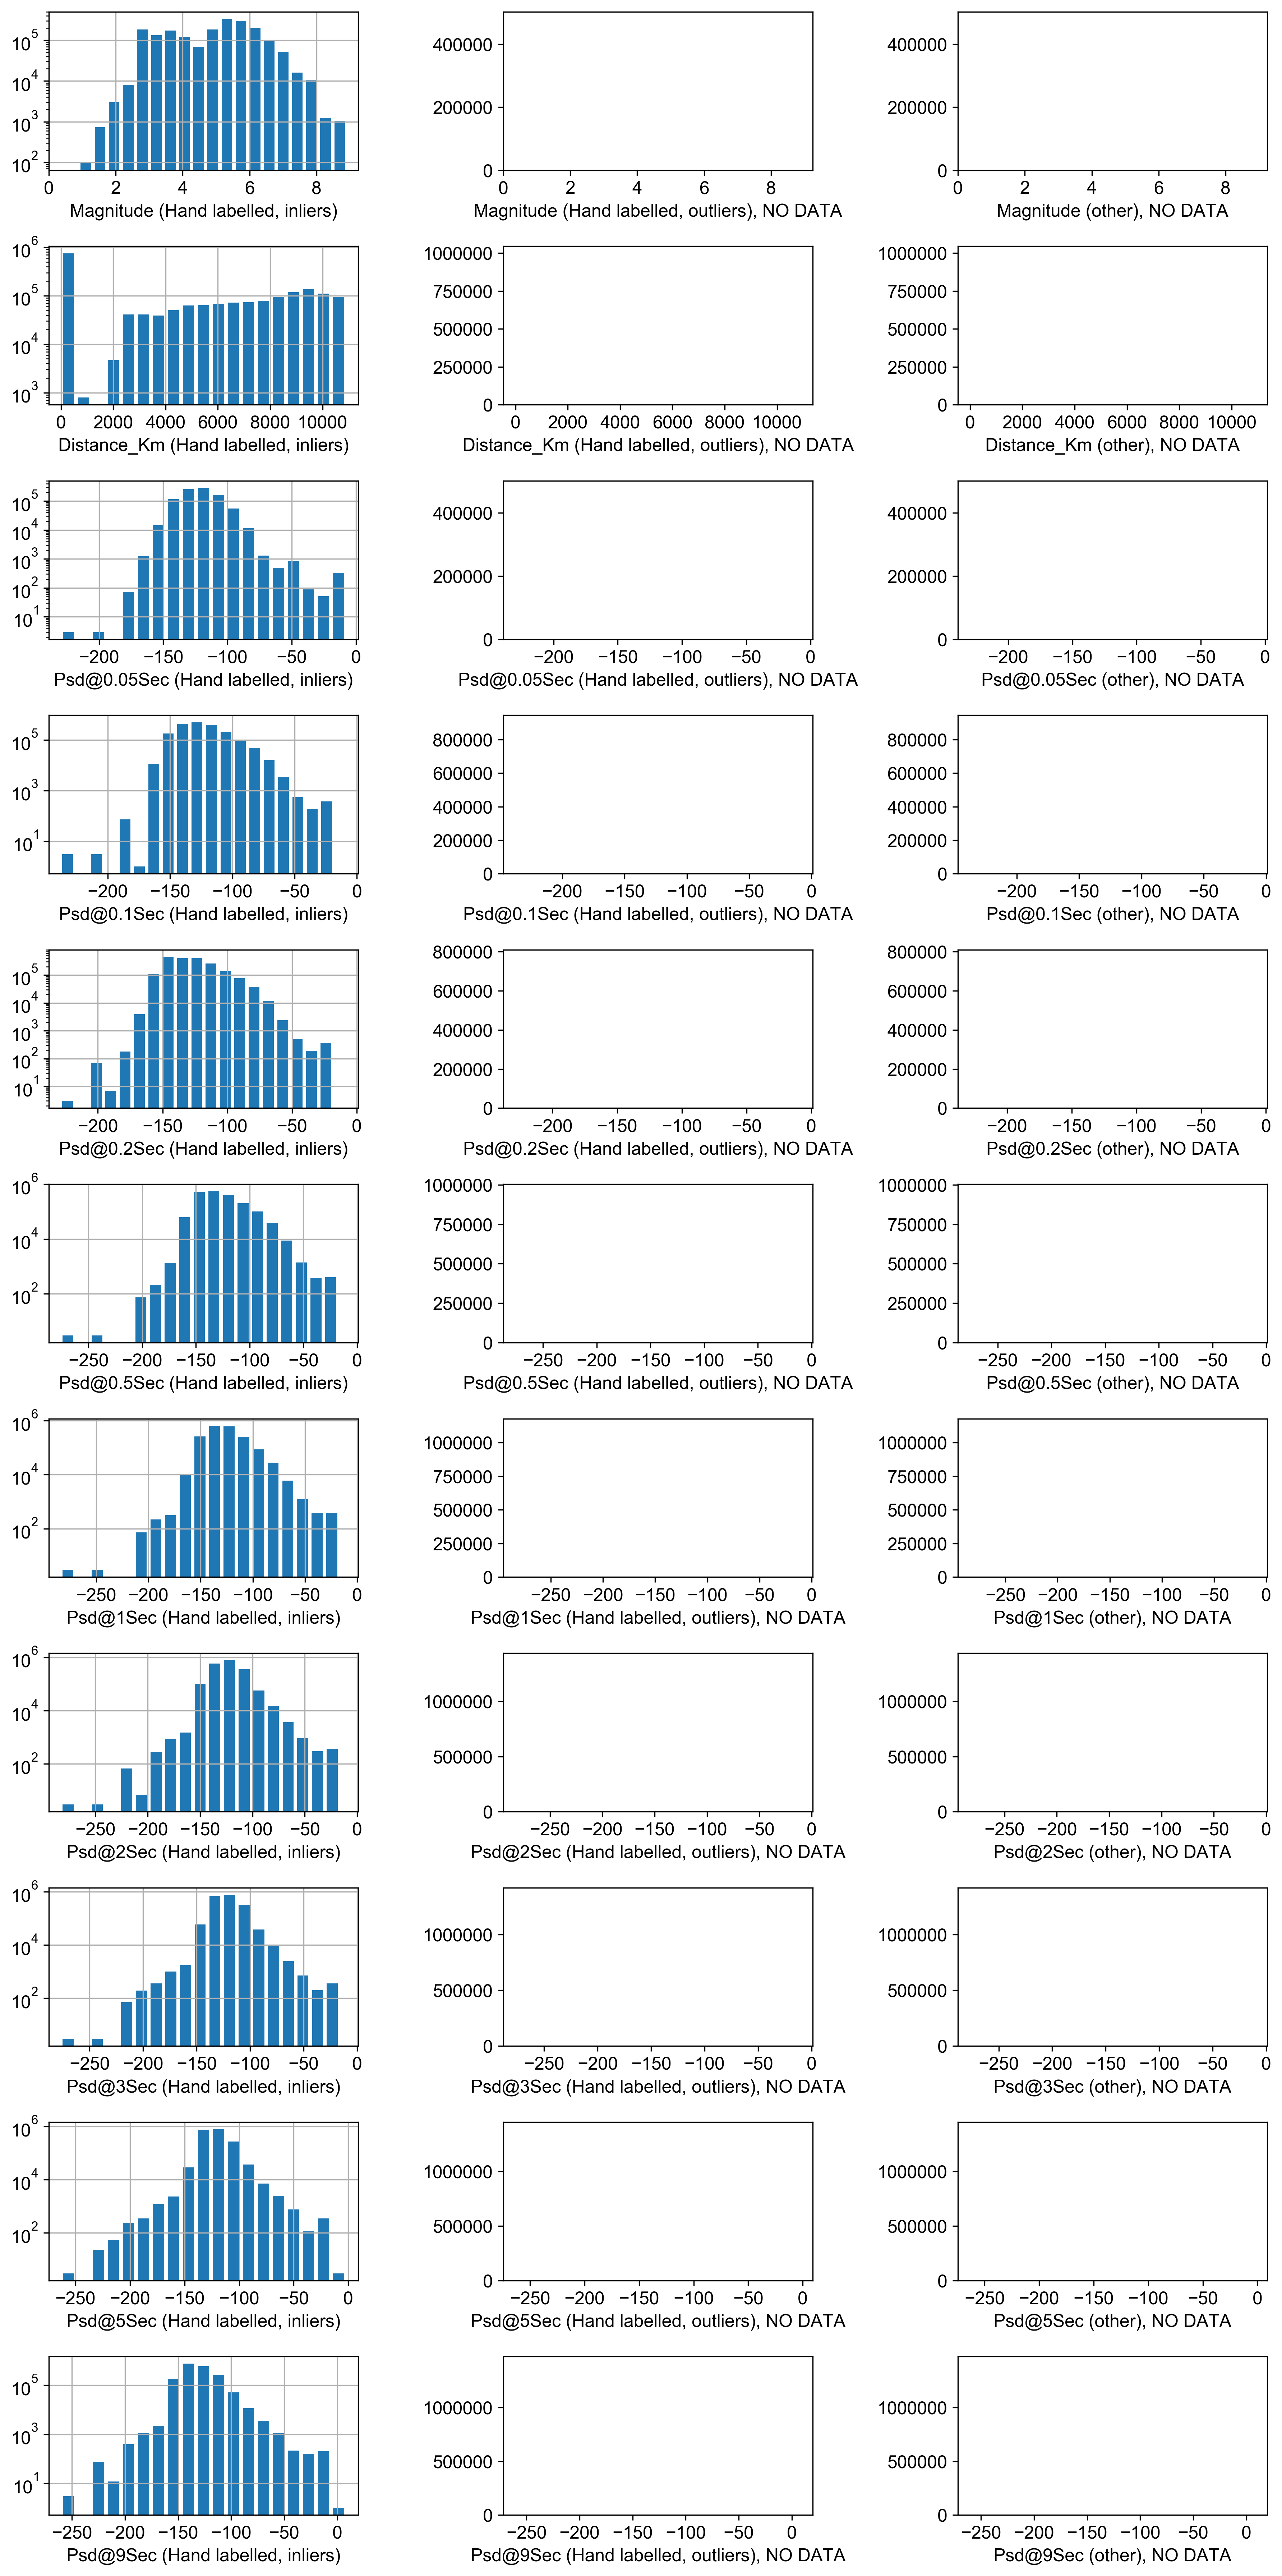



allset_test: distributions


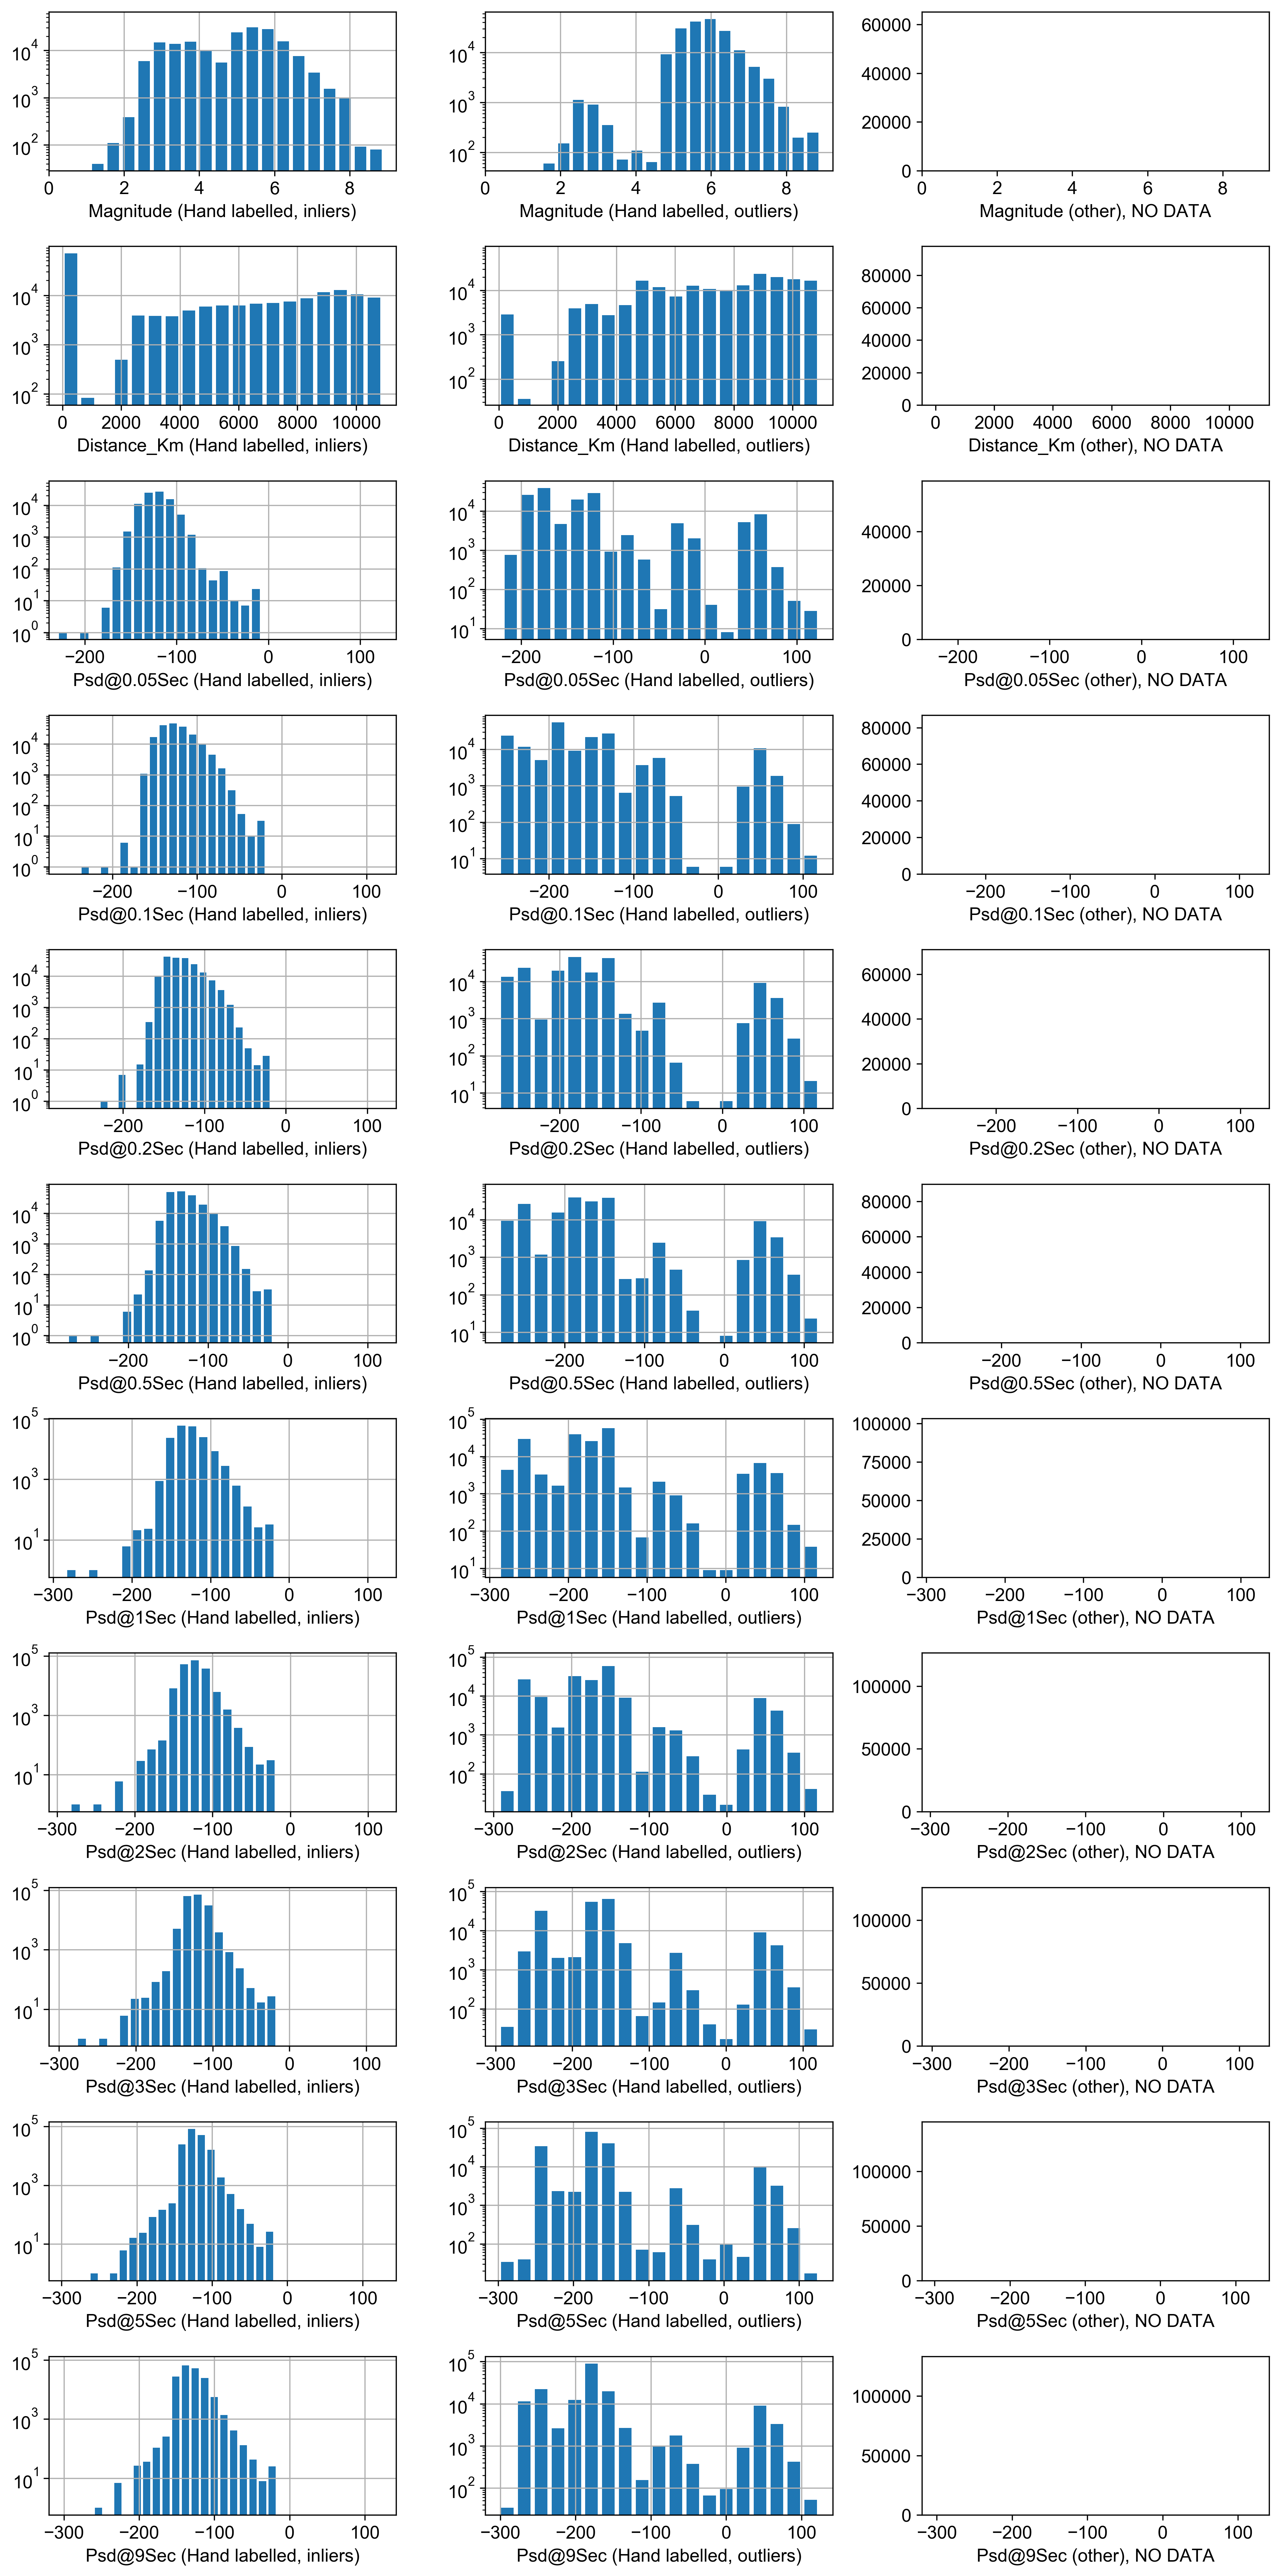

In [6]:
# distributions plots of newly created datasets (train, test, unlabelled, artifacts)
for name, dataset in new_datasets.items():
    print()
    print_dec('%s: distributions' % name)
    plot_dist(dataset)

In [7]:
# Saving newly created datasets (train, test, unlabelled, artifacts)
for name, dataset in new_datasets.items():
    print_dec('Saving dataset "%s"' % name)
    save_dataset(dataset, name)


Saving dataset "allset_artifacts"
File saved under /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_artifacts.hdf

Saving dataset "allset_unlabelled"
File saved under /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_unlabelled.hdf

Saving dataset "allset_train"
File saved under /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_train.hdf

Saving dataset "allset_test"
File saved under /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_test.hdf
